Imports

In [12]:
import os
import glob
import json
import re
import hashlib
import duckdb
import pandas as pd
import numpy as np
import pyarrow as pa
import pyarrow.parquet as pq
import pyarrow.dataset as ds
import torch
import yfinance as yf
from unidecode import unidecode
from simhash import Simhash, SimhashIndex
from sentence_transformers import SentenceTransformer
import faiss
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from tqdm.auto import tqdm
from scipy.stats import norm, skew, kurtosis, linregress
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

Config

In [ ]:
# Directories
RAW_DIR = "./data/raw"
TEMP_DIR = "./data/temp"
PROCESSED_DIR = "./data/processed"
CHUNKS_DIR = "sentiment_chunks"

# Files
COMBINED_FILE = os.path.join(PROCESSED_DIR, "combined.parquet")
DEDUPED_FILE = os.path.join(PROCESSED_DIR, "de-duplicated.parquet")
FINAL_FILE = "sentiment_dataset.parquet"
MARKET_FILE = "Bloomberg.xlsx"

# Params
SIMHASH_BITS = 64
SIMHASH_K = 3
EMB_MODEL = "sentence-transformers/all-MiniLM-L6-v2"
COS_THRESH = 0.90
TOPK = 10
BATCH_SIZE = 128
CHUNK_SIZE = 10000

# BUCKETS for Sentiment
BUCKETS = {
    'macro': [
        'fed', 'federal reserve', 'powell',
        'interest rate', 'interest rates', 'rate hike', 'rate cut',
        'inflation', 'disinflation', 'deflation',
        'cpi', 'ppi', 'pce',
        'treasury', 'treasuries', 'bond', 'bonds',
        'yield', 'yields', 'yield curve', 'inversion',
        'recession', 'slowdown', 'economic contraction',
        'soft landing', 'hard landing',
        'economy', 'economic growth', 'gdp',
        'labor market', 'jobs', 'employment', 'unemployment',
        'monetary policy', 'tightening', 'easing'
    ],

    'tech': [
        'apple', 'aapl',
        'microsoft', 'msft',
        'nvidia', 'nvda',
        'google', 'alphabet', 'googl', 'goog',
        'amazon', 'amzn',
        'meta', 'facebook',
        'tesla', 'tsla',
        'ai', 'artificial intelligence', 'machine learning',
        'semiconductor', 'semiconductors', 'chip', 'chips',
        'data center', 'cloud', 'cloud computing',
        'software', 'hardware', 'saas',
        'tech', 'technology',
        'nasdaq', 'nasdaq 100',
        'big tech'
    ],

    'energy': [
        'oil', 'crude', 'crude oil',
        'brent', 'wti',
        'natural gas', 'gas', 'lng',
        'energy',
        'exxon', 'exxonmobil', 'xom',
        'chevron', 'cvx',
        'shell', 'bp',
        'opec', 'opec+',
        'production', 'output', 'supply',
        'production cuts',
        'drilling', 'rig count',
        'refinery', 'refining',
        'renewable', 'renewables',
        'solar', 'wind'
    ]
}

os.makedirs(TEMP_DIR, exist_ok=True) 
os.makedirs(PROCESSED_DIR, exist_ok=True)
os.makedirs(CHUNKS_DIR, exist_ok=True)

Enrich dataset

In [ ]:
def step_1_enrich():
    
    shards = sorted(glob.glob(os.path.join(RAW_DIR, "shard_*.parquet")))
    
    # 1. Enrich individual shards
    for i, src in enumerate(shards, 1):
        out_path = os.path.join(TEMP_DIR, os.path.basename(src))
        if os.path.exists(out_path): continue

        try:
            df = pd.read_parquet(src)
            
            if 'date' in df.columns:
                df['date'] = pd.to_datetime(df['date'])
                df = df[df['date'] >= '2016-01-01']
            
            if len(df) == 0: continue

            if "extra_fields" in df.columns:
                def parse(x):
                    try: return json.loads(x).get("publication"), json.loads(x).get("author")
                    except: return None, None
                
                parsed = [parse(x) for x in df["extra_fields"].fillna("")]
                df["publication"], df["author"] = zip(*parsed)
            else:
                df["publication"], df["author"] = None, None

            table = pa.Table.from_pandas(df, preserve_index=False)
            pq.write_table(table, out_path, compression="snappy")
            
        except Exception as e:
            print(f"Error {src}: {e}")

    # 2. Combine (Streaming Mode)
    if not os.path.exists(COMBINED_FILE):
        print("Combining shards...")
        dataset = ds.dataset(TEMP_DIR, format="parquet")
        with pq.ParquetWriter(COMBINED_FILE, dataset.schema, compression="snappy") as writer:
            for batch in dataset.to_batches():
                writer.write_batch(batch)

In [ ]:
step_1_enrich()

Deduplication (Hybrid SimHash/SBERT)

In [ ]:
def step_2_dedupe():
    
    con = duckdb.connect()
    # Get distinct dates
    dates = con.execute(f"""
        SELECT DISTINCT date FROM read_parquet('{COMBINED_FILE}') 
        WHERE date >= '2016-01-01' 
        ORDER BY date
    """).df()["date"].tolist()
    
    model = SentenceTransformer(EMB_MODEL)
    dedupe_temp_dir = os.path.join(PROCESSED_DIR, "dedupe_temp")
    os.makedirs(dedupe_temp_dir, exist_ok=True)

    print(f"Processing {len(dates)} days...")
    
    for d in dates:
        date_str = pd.to_datetime(d).strftime('%Y-%m-%d')
        out_shard = os.path.join(dedupe_temp_dir, f"dedup_{date_str}.parquet")

        if os.path.exists(out_shard): continue

        day_df = con.execute(f"SELECT * FROM read_parquet('{COMBINED_FILE}') WHERE date = ?", [d]).df()
        if len(day_df) == 0: continue

        # 1. Normalization
        _ws = re.compile(r"\s+")
        _punct = re.compile(r"[^\w\s]")
        
        def normalize_text(s):
            if not isinstance(s, str): return ""
            s = unidecode(s).lower()
            s = re.sub(r"^\((reuters|ap|bloomberg|afp)\)\s*[-–—]?\s*", "", s)
            s = _punct.sub(" ", s)
            return _ws.sub(" ", s).strip()
            
        day_df["norm_news"] = day_df["text"].apply(normalize_text)
        day_df = day_df.drop_duplicates(subset=["norm_news"], keep="first").reset_index(drop=True)

        # 2. SimHash
        def simhash_tokens(s):
            words = s.split()
            return [" ".join(words[i:i+3]) for i in range(max(1, len(words)-2))]
            
        day_df["doc_id"] = day_df.apply(lambda r: hashlib.sha1((str(r["date"])+r["norm_news"][:512]).encode()).hexdigest(), axis=1)
        objs = [(r["doc_id"], Simhash(simhash_tokens(r["norm_news"]), f=SIMHASH_BITS)) for _, r in day_df.iterrows()]
        index = SimhashIndex(objs, k=SIMHASH_K)

        parent = {doc_id: doc_id for doc_id, _ in objs}
        def find(x):
            while parent[x] != x:
                parent[x] = parent[parent[x]]
                x = parent[x]
            return x
        def union(a, b):
            ra, rb = find(a), find(b)
            if ra != rb: parent[rb] = ra

        for doc_id, sh in objs:
            for nid in index.get_near_dups(sh):
                union(doc_id, nid)

        # 3. SBERT + FAISS (Batch Size 128)
        corpus = day_df["norm_news"].tolist()
        if len(corpus) > 0:
            emb = model.encode(corpus, BATCH_SIZE=256, show_progress_bar=False, normalize_embeddings=True).astype("float32")
            
            idx = faiss.IndexFlatIP(emb.shape[1])
            idx.add(emb)
            sims, ids = idx.search(emb, min(TOPK, len(corpus))) # Safety check for TOPK

            row_ids = day_df["doc_id"].tolist()
            for i in range(len(day_df)):
                for j in range(1, ids.shape[1]): # Skip self (index 0)
                    if ids[i, j] >= 0 and sims[i, j] >= COS_THRESH:
                        union(row_ids[i], row_ids[ids[i, j]])

        # 4. Cluster Reps
        def choose_rep(df_subset):
            df_subset = df_subset.copy()
            df_subset["len"] = df_subset["text"].astype(str).str.len()
            df_subset = df_subset.sort_values(["len", "publication"], ascending=[False, True])
            return df_subset.iloc[0]

        day_df["cluster"] = day_df["doc_id"].apply(find)
        deduped_rows = []
        for _, grp in day_df.groupby("cluster"):
            deduped_rows.append(choose_rep(grp))
        
        final_df = pd.DataFrame(deduped_rows).drop(columns=["norm_news", "doc_id", "cluster", "len"])
        final_df.to_parquet(out_shard)

    # Combine Dedupe Shards (Streaming to avoid OOM Error)
    print("Merging deduped shards...")
    if not os.path.exists(DEDUPED_FILE):
        dataset = ds.dataset(dedupe_temp_dir, format="parquet")
        with pq.ParquetWriter(DEDUPED_FILE, dataset.schema, compression="snappy") as writer:
            for batch in dataset.to_batches():
                writer.write_batch(batch)
                
    con.close()
    print(f"Saved {DEDUPED_FILE}")

In [ ]:
step_2_dedupe()

Score Sentiment with FinBERT

In [ ]:
def step_3_score():
    
    def get_bucket(text):
        t = text.lower()
        for cat, kws in BUCKETS.items():
            if any(k in t for k in kws): return cat
        return 'general'

    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Using device: {device}")

    # Check if we need to run
    con = duckdb.connect()
    total_rows = con.execute(f"SELECT COUNT(*) FROM '{DEDUPED_FILE}'").fetchone()[0]
    
    # Simple check: if chunks exist covering most rows, skip
    existing_chunks = glob.glob(f"{CHUNKS_DIR}/part_*.parquet")
    if len(existing_chunks) > (total_rows // CHUNK_SIZE) * 0.9:
        print("Most chunks exist. Skipping scoring.")
        return

    tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
    model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert").to(device)

    for i in tqdm(range(0, total_rows, CHUNK_SIZE), desc="Scoring Chunks", unit="chunk"):
        outfile = f"{CHUNKS_DIR}/part_{i}.parquet"
        if os.path.exists(outfile): continue

        df = con.execute(f"SELECT date, text FROM '{DEDUPED_FILE}' LIMIT {CHUNK_SIZE} OFFSET {i}").df()
        if df.empty: break

        df['bucket'] = df['text'].astype(str).apply(get_bucket)
        texts = df['text'].astype(str).tolist()
        sentiments = []

        for j in range(0, len(texts), BATCH_SIZE):
            batch = texts[j : j+BATCH_SIZE]
            inputs = tokenizer(batch, return_tensors="pt", padding=True, truncation=True, max_length=64).to(device)
            with torch.no_grad():
                outputs = model(**inputs)
                probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
                scores = (probs[:, 0] - probs[:, 1]).cpu().numpy()
                sentiments.extend(scores)
        
        df['sentiment'] = sentiments
        df['date'] = pd.to_datetime(df['date']).dt.normalize()
        
        # Aggregate immediately to save space
        chunk_agg = df.groupby(['date', 'bucket']).agg(
            sum_sent=('sentiment', 'sum'),
            count=('sentiment', 'count')
        ).reset_index()
        
        chunk_agg.to_parquet(outfile)

    con.close()

In [ ]:
step_3_score()

Aggregate chunks and align trading days

In [ ]:
def step_4_finalize():

    # 1. Load Chunks
    files = glob.glob(f"{CHUNKS_DIR}/*.parquet")
    if not files:
        print("No chunks found!")
        return
    
    full_df = pd.concat([pd.read_parquet(f) for f in files])
    
    # 2. Daily Aggregation
    daily_final = full_df.groupby(['date', 'bucket']).sum().unstack()
    
    features = pd.DataFrame(index=daily_final.index)
    all_BUCKETS = list(BUCKETS.keys()) + ['general']
    
    for b in all_BUCKETS:
        if ('sum_sent', b) in daily_final.columns:
            s_sum = daily_final[('sum_sent', b)]
            cnt = daily_final[('count', b)]
            
            # Avg Sentiment & Log Volume
            features[f'sent_{b}'] = s_sum / cnt.replace(0, 1)
            features[f'vol_{b}'] = np.log1p(cnt)
            
    features = features.fillna(0).sort_index()

    features.index = features.index.astype('datetime64[ns]')
    
    # 3. Get Trading Calendar
    print("Fetching Trading Calendar...")
    price_df = yf.download("^GSPC", start="2010-01-01", end="2026-01-01", progress=False, auto_adjust=False)
    if isinstance(price_df.columns, pd.MultiIndex): 
        price_df.columns = price_df.columns.get_level_values(0)
    
    price_df = price_df.reset_index()
    if 'Date' not in price_df.columns: 
        price_df.rename(columns={price_df.columns[0]: 'Date'}, inplace=True)
    
    price_df['Date'] = pd.to_datetime(price_df['Date']).dt.normalize()
    price_df = price_df.set_index('Date')
    price_df = price_df[[]] # Keep index only
    
    price_df.index = price_df.index.astype('datetime64[ns]')
    
    # 4. Merge (Forward Fill - Weekend News moves to Monday)
    print("Aligning to Trading Days...")

    combined = pd.merge_asof(features, price_df, left_index=True, right_index=True, direction='forward').dropna()
    
    # 5. Save
    combined.to_parquet(FINAL_FILE)
    print(f"FINAL FILE GENERATED: {FINAL_FILE}")
    print(combined.head())

In [ ]:
step_4_finalize()

Align Bloomberg market data with final dataset

In [3]:
def step_5_alignment(sent_path, mkt_path):

    raw = pd.read_excel(mkt_path, header=1)

    # Extract Price
    df_price = raw.iloc[:, [0, 1, 2]].copy()
    df_price.columns = ['Date', 'Spot', 'Div_Yield']
    df_price['Date'] = pd.to_datetime(df_price['Date'], errors='coerce')
    df_price = df_price.dropna(subset=['Date']).set_index('Date')

    # Extract Volatility
    df_iv = raw.iloc[:, [4, 5]].copy()
    df_iv.columns = ['Date', 'IV']
    df_iv['Date'] = pd.to_datetime(df_iv['Date'], errors='coerce')
    df_iv = df_iv.dropna(subset=['Date']).set_index('Date')

    # Extract Rates
    df_rate = raw.iloc[:, [7, 8]].copy()
    df_rate.columns = ['Date', 'Rate']
    df_rate['Date'] = pd.to_datetime(df_rate['Date'], errors='coerce')
    df_rate = df_rate.dropna(subset=['Date']).set_index('Date')

    # Inner Join
    market_df = df_price.join(df_iv, how='inner').join(df_rate, how='left')
    market_df['Rate'] = market_df['Rate'].ffill()

    # Normalize Units
    market_df['Div_Yield'] /= 100.0
    market_df['IV'] /= 100.0
    market_df['Rate'] /= 100.0
    
    # Load Sentiment
    sent_df = pd.read_parquet(sent_path)
    if 'date' in sent_df.columns:
        sent_df['date'] = pd.to_datetime(sent_df['date'])
        sent_df = sent_df.set_index('date')
    
    # Final Merge
    df = market_df.join(sent_df.iloc[:, 0].rename('sentiment'), how='left').ffill().fillna(0)
    df['ret_asset'] = df['Spot'].pct_change().fillna(0)
    
    print(f"Data Loaded: {df.index.min().date()} to {df.index.max().date()}")
    return df

In [4]:
df = step_5_alignment(FINAL_FILE, MARKET_FILE)

Data Loaded: 2016-01-15 to 2025-12-01


Black-Scholes Pricing for calculating Puts and Payoff

In [5]:
def get_bs_put(S, K, T, r, q, sigma):

    if sigma <= 0 or T <= 0: 
        return 0.0
    
    d1 = (np.log(S/K) + (r - q + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return (K * np.exp(-r * T) * norm.cdf(-d2)) - (S * np.exp(-q * T) * norm.cdf(-d1))

def step_6_option_payoffs(df):

    opt_rets = []
    Moneyness = 0.90 
    
    for i in range(len(df) - 1):
        today = df.iloc[i]
        tomorrow = df.iloc[i+1]
        
        p_buy = get_bs_put(today['Spot'], today['Spot']*Moneyness, 90/365.0, 
                           today['Rate'], today['Div_Yield'], today['IV'])
        
        p_sell = get_bs_put(tomorrow['Spot'], today['Spot']*Moneyness, 89/365.0, 
                            today['Rate'], today['Div_Yield'], tomorrow['IV'])
        
        if p_buy > 0.01:
            opt_rets.append((p_sell - p_buy) / p_buy)
        else:
            opt_rets.append(0.0)
            
    opt_rets.append(0.0)
    df['ret_put'] = opt_rets
    return df

In [6]:
df = step_6_option_payoffs(df)

Strategy Engine

In [7]:
def step_7_strategy(df):
    
    # A. Feature Engineering
    # 1. Trend Filter (The "Veto")
    df['ma_200'] = df['Spot'].rolling(window=200).mean()
    df['trend_up'] = (df['Spot'] > df['ma_200']) 
    
    # 2. Momentum Lock (The "Safety")
    df['ma_45'] = df['Spot'].rolling(window=45).mean()
    df['mom_weak'] = (df['Spot'] < df['ma_45']) # True if Price < 45MA
    
    # 3. Sentiment Z-Scores
    windows = [15, 30, 45, 60, 75, 90, 120]
    for w in windows:
        roll_mean = df['sentiment'].rolling(w).mean()
        roll_std = df['sentiment'].rolling(w).std()
        df[f'z_{w}'] = ((df['sentiment'] - roll_mean) / (roll_std + 1e-6)).shift(1).fillna(0)

    # B. Simulation Loop
    years = sorted(df.index.year.unique())
    results_list = []
    
    # Hyperparams to Search
    z_trigs = [-1.0, -1.25, -1.5, -1.75, -2.0]
    allocs = [0.02, 0.05, 0.08, 0.10]
    
    print(f"{'Year':<6} | {'Win/Trig/Alloc':<20} | {'Return':<8}")
    print("-" * 40)

    for i in range(2, len(years)):
        test_year = years[i]
        train_years = [years[i-2], years[i-1]]
        
        train = df[df.index.year.isin(train_years)].copy()
        test = df[df.index.year == test_year].copy()
        
        if len(test) == 0: continue
        
        # --- TRAINING ---
        best_score = -999
        best_params = (90, -1.5, 0.05)
        
        for w in windows:
            for z in z_trigs:
                for a in allocs:
                    # LOGIC:
                    # 1. Trend UP -> Long Asset
                    # 2. Trend DOWN + Sentiment BAD + Momentum WEAK -> Hedge
                    # 3. Else -> Cash
                    
                    cond_up = train['trend_up']
                    cond_fear = (train[f'z_{w}'] < z)
                    cond_mom = train['mom_weak']
                    
                    # Vectorized PnL: Only hedge if Fear AND Weak Momentum
                    rets = np.where(cond_up, train['ret_asset'],
                                    np.where(cond_fear & cond_mom, a * train['ret_put'], 0.0))
                    
                    if rets.sum() > best_score:
                        best_score = rets.sum()
                        best_params = (w, z, a)
        
        # --- TESTING ---
        w_opt, z_opt, a_opt = best_params
        
        cond_up_test = test['trend_up']
        cond_fear_test = (test[f'z_{w_opt}'] < z_opt)
        cond_mom_test = test['mom_weak']
        
        # Record State: 1=Long, 2=Hedge, 0=Cash
        # Hedge (2) only happens if Trend Down AND Fear AND Momentum Weak
        test['state'] = np.select(
            [cond_up_test, (~cond_up_test) & (cond_fear_test) & (cond_mom_test)], 
            [1, 2], 
            default=0
        )
        
        test['strat_ret'] = np.where(test['state']==1, test['ret_asset'],
                                     np.where(test['state']==2, a_opt * test['ret_put'], 0.0))
        
        results_list.append(test)
        
        yr_ret = (np.prod(1 + test['strat_ret']) - 1) * 100
        print(f"{test_year:<6} | {str(best_params):<20} | {yr_ret:>6.1f}%")

    return pd.concat(results_list)

In [8]:
res_df = step_7_strategy(df)

Year   | Win/Trig/Alloc       | Return  
----------------------------------------
2018   | (60, -2.0, 0.1)      |   30.3%
2019   | (120, -2.0, 0.1)     |    1.6%
2020   | (30, -1.25, 0.1)     |  289.6%
2021   | (30, -1.0, 0.1)      |   47.4%
2022   | (30, -1.25, 0.1)     |   67.5%
2023   | (15, -2.0, 0.02)     |    8.3%
2024   | (30, -1.0, 0.1)      |   34.4%
2025   | (30, -1.0, 0.1)      |   26.9%


Calculate Returns and Visualization


 FINAL RESULTS (2018-2025)
Strategy Total Return: 2249.50%
Benchmark (XLE) Return: 26.38%


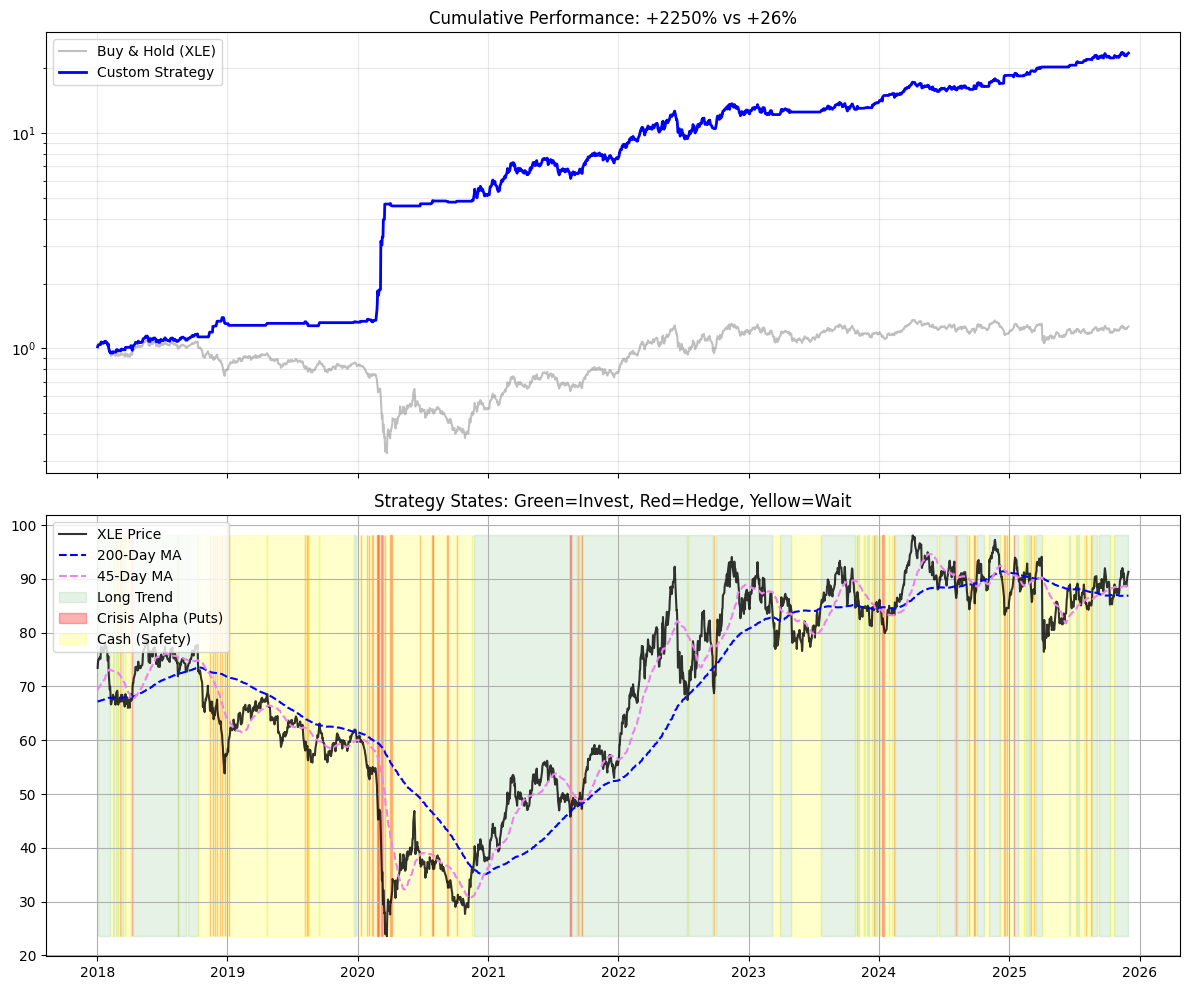


--- RECENT TRADE SIGNALS ---
2025-07-30 | Switched to: CASH (Price: 87.68)
2025-08-05 | Switched to: LONG PUTS (Price: 85.51)
2025-08-06 | Switched to: CASH (Price: 84.72)
2025-08-18 | Switched to: LONG PUTS (Price: 85.05)
2025-08-19 | Switched to: CASH (Price: 85.08)
2025-08-22 | Switched to: LONG XLE (Price: 88.14)
2025-09-08 | Switched to: CASH (Price: 87.16)
2025-09-09 | Switched to: LONG XLE (Price: 87.58)
2025-10-10 | Switched to: CASH (Price: 85.22)
2025-10-22 | Switched to: LONG XLE (Price: 87.80)


In [11]:
# 1. Cumulative Metrics
res_df['cum_strat'] = (1 + res_df['strat_ret']).cumprod()
res_df['cum_hold'] = (1 + res_df['ret_asset']).cumprod()

total_strat = (res_df['cum_strat'].iloc[-1] - 1) * 100
total_hold = (res_df['cum_hold'].iloc[-1] - 1) * 100

print("\n========================================")
print(f" FINAL RESULTS (2018-2025)")
print("========================================")
print(f"Strategy Total Return: {total_strat:.2f}%")
print(f"Benchmark (XLE) Return: {total_hold:.2f}%")

# 2. Visualization Dashboard
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# Plot 1: Equity Curve
ax1.plot(res_df.index, res_df['cum_hold'], label='Buy & Hold (XLE)', color='gray', alpha=0.5)
ax1.plot(res_df.index, res_df['cum_strat'], label='Custom Strategy', color='blue', linewidth=2)
ax1.set_yscale('log')
ax1.set_title(f"Cumulative Performance: +{total_strat:.0f}% vs +{total_hold:.0f}%")
ax1.legend()
ax1.grid(True, which='both', alpha=0.3)

# Plot 2: Trade Anatomy (Price vs 200MA vs Decisions)
ax2.plot(res_df.index, res_df['Spot'], label='XLE Price', color='black', alpha=0.8)
ax2.plot(res_df.index, res_df['ma_200'], label='200-Day MA', color='blue', linestyle='--')
ax2.plot(res_df.index, res_df['ma_45'], label='45-Day MA', color='violet', linestyle='--')

# Highlight Regimes
# Green = Long, Red = Puts, Yellow = Cash
y_min, y_max = res_df['Spot'].min(), res_df['Spot'].max()
ax2.fill_between(res_df.index, y_min, y_max, where=(res_df['state']==1), color='green', alpha=0.1, label='Long Trend')
ax2.fill_between(res_df.index, y_min, y_max, where=(res_df['state']==2), color='red', alpha=0.3, label='Crisis Alpha (Puts)')
ax2.fill_between(res_df.index, y_min, y_max, where=(res_df['state']==0), color='yellow', alpha=0.2, label='Cash (Safety)')

ax2.set_title("Strategy States: Green=Invest, Red=Hedge, Yellow=Wait")
ax2.legend(loc='upper left')
ax2.grid(True)

plt.tight_layout()
plt.show()

# 4. Trade Log (Last 10 Changes)
print("\n--- RECENT TRADE SIGNALS ---")
res_df['prev_state'] = res_df['state'].shift(1)
trades = res_df[res_df['state'] != res_df['prev_state']].dropna().tail(10)

state_map = {0: 'CASH', 1: 'LONG XLE', 2: 'LONG PUTS'}
for dt, row in trades.iterrows():
    print(f"{dt.date()} | Switched to: {state_map[row['state']]} (Price: {row['Spot']:.2f})")

Detailed metrics

In [13]:
def calculate_metrics(df, strat_col='strat_ret', bench_col='ret_asset', rf_col='Rate'):

    # 1. Prep Data
    # Risk Free Rate (Daily)
    if rf_col in df.columns:
        rf = df[rf_col] / 252 # Assuming Rate is annualized
    else:
        rf = 0.04 / 252 # Default to 4% if missing
        
    excess_strat = df[strat_col] - rf
    excess_bench = df[bench_col] - rf
    
    # 2. Return Metrics
    days = len(df)
    cagr_strat = (1 + df[strat_col]).prod() ** (252 / days) - 1
    cagr_bench = (1 + df[bench_col]).prod() ** (252 / days) - 1
    
    total_ret = (1 + df[strat_col]).prod() - 1
    
    # 3. Risk Metrics (Sharpe & Sortino)
    std_strat = df[strat_col].std() * np.sqrt(252)
    sharpe = (excess_strat.mean() * 252) / std_strat
    
    # Sortino: Only punish downside volatility
    downside_rets = df[df[strat_col] < 0][strat_col]
    downside_std = downside_rets.std() * np.sqrt(252)
    sortino = (excess_strat.mean() * 252) / (downside_std + 1e-6)
    
    # 4. Drawdown Dynamics
    cum_ret = (1 + df[strat_col]).cumprod()
    running_max = cum_ret.cummax()
    drawdown = (cum_ret / running_max) - 1
    max_dd = drawdown.min()
    
    calmar = cagr_strat / abs(max_dd)
    
    # 5. Tail Risk (Skew, Kurtosis, VaR, CVaR)
    skew_val = skew(df[strat_col])
    kurt_val = kurtosis(df[strat_col])
    
    # 95% Value at Risk (VaR)
    var_95 = np.percentile(df[strat_col], 5)
    # Conditional VaR (Expected Shortfall)
    cvar_95 = df[df[strat_col] <= var_95][strat_col].mean()
    
    # 6. Correlation & Beta
    slope, intercept, r_value, p_value, std_err = linregress(excess_bench, excess_strat)
    beta = slope
    alpha_annual = (1 + intercept) ** 252 - 1
    
    # 7. Win Rate & Profit Factor
    wins = df[df[strat_col] > 0][strat_col]
    losses = df[df[strat_col] < 0][strat_col]
    win_rate = len(wins) / len(df)
    profit_factor = abs(wins.sum() / losses.sum())
    
    # --- PRINT REPORT ---
    print("\n" + "="*50)
    print(f" STRATEGY PERFORMANCE REPORT")
    print("="*50)
    print(f"{'Metric':<25} | {'Strategy':<10} | {'Benchmark':<10}")
    print("-" * 55)
    print(f"{'Total Return':<25} | {total_ret:>9.1%} | {(1+df[bench_col]).prod()-1:>9.1%}")
    print(f"{'CAGR (Ann. Return)':<25} | {cagr_strat:>9.1%} | {cagr_bench:>9.1%}")
    print(f"{'Sharpe Ratio':<25} | {sharpe:>9.2f} | {(excess_bench.mean()*252)/(excess_bench.std()*np.sqrt(252)):>9.2f}")
    print(f"{'Sortino Ratio':<25} | {sortino:>9.2f} | {'-':>9}")
    print(f"{'Calmar Ratio':<25} | {calmar:>9.2f} | {cagr_bench/abs(((1+df[bench_col]).cumprod()/((1+df[bench_col]).cumprod().cummax())-1).min()):>9.2f}")
    print("-" * 55)
    print(f"{'Max Drawdown':<25} | {max_dd:>9.1%} | {((1+df[bench_col]).cumprod()/((1+df[bench_col]).cumprod().cummax())-1).min():>9.1%}")
    print(f"{'Beta (Correlation)':<25} | {beta:>9.2f} | {'1.00':>9}")
    print(f"{'Alpha (Annualized)':<25} | {alpha_annual:>9.1%} | {'-':>9}")
    print("-" * 55)
    print(f"{'Skewness':<25} | {skew_val:>9.2f} | {skew(df[bench_col]):>9.2f}")
    print(f"{'Kurtosis (Fat Tails)':<25} | {kurt_val:>9.2f} | {kurtosis(df[bench_col]):>9.2f}")
    print(f"{'95% CVaR (Tail Risk)':<25} | {cvar_95:>9.1%} | {df[df[bench_col]<=np.percentile(df[bench_col],5)][bench_col].mean():>9.1%}")
    print(f"{'Profit Factor':<25} | {profit_factor:>9.2f} | {abs(df[df[bench_col]>0][bench_col].sum()/df[df[bench_col]<0][bench_col].sum()):>9.2f}")
    print(f"{'Win Rate':<25} | {win_rate:>9.1%} | {len(df[df[bench_col]>0])/len(df):>9.1%}")
    print("="*50)
    
    return {
        'Sharpe': sharpe, 'Sortino': sortino, 'MaxDD': max_dd, 
        'CAGR': cagr_strat, 'Beta': beta, 'CVaR': cvar_95
    }

if 'res_df' in locals():
    metrics = calculate_metrics(res_df, strat_col='strat_ret', bench_col='ret_asset', rf_col='Rate')
else:
    print("Error: 'res_df' not found. Please run the WFO strategy first.")


 STRATEGY PERFORMANCE REPORT
Metric                    | Strategy   | Benchmark 
-------------------------------------------------------
Total Return              |   2249.5% |     26.4%
CAGR (Ann. Return)        |     49.1% |      3.0%
Sharpe Ratio              |      1.24 |      0.17
Sortino Ratio             |      2.31 |         -
Calmar Ratio              |      1.91 |      0.04
-------------------------------------------------------
Max Drawdown              |    -25.8% |    -70.1%
Beta (Correlation)        |      0.36 |      1.00
Alpha (Annualized)        |     49.6% |         -
-------------------------------------------------------
Skewness                  |     16.34 |     -0.50
Kurtosis (Fat Tails)      |    486.92 |     12.78
95% CVaR (Tail Risk)      |     -3.2% |     -4.6%
Profit Factor             |      1.54 |      1.05
Win Rate                  |     33.2% |     52.3%
